In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt
import os
import random
import json

In [2]:
def build_autoencoder(input_shape=(224, 224, 1)):
    # Encoder
    input_img = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    # Decoder
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    # Model
    autoencoder = Model(input_img, decoded)
    return autoencoder

In [3]:
autoencoder = build_autoencoder()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 1)    │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,329,153 (5.07 MB)

 Trainable params: 1,329,153 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# Set the random seed for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)


In [9]:
def load_and_preprocess_images(image_dir, num_images):
    image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('.jpg')]
    random.shuffle(image_paths)
    selected_paths = image_paths[:num_images]
    
    images = []
    for path in selected_paths:
        img = load_img(path, color_mode='grayscale', target_size=(224, 224))
        img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
        images.append(img_array)
    
    images = np.array(images)
    images = images.reshape((len(images), 224, 224, 1))
    
    return images, selected_paths


In [11]:
# Load and preprocess the normal and misbehavior images
normal_image_dir = "/Users/mohitkukreja/Desktop/TEA_Lab/data_side_lane/images"  
misbehavior_image_dir = "/Users/mohitkukreja/Desktop/TEA_Lab/data/images" 

normal_images, normal_paths = load_and_preprocess_images(normal_image_dir, 990)
misbehavior_images, misbehavior_paths = load_and_preprocess_images(misbehavior_image_dir, 10)

In [12]:
# Combine the normal and misbehavior images
images = np.concatenate((normal_images, misbehavior_images), axis=0)

In [15]:
# If necessary, reshape images to include the channel dimension
images = images.reshape((len(images), 224, 224, 1))

In [17]:
images

array([[[[0.29803923],
         [0.30588236],
         [0.30980393],
         ...,
         [0.4745098 ],
         [0.49411765],
         [0.5411765 ]],

        [[0.29803923],
         [0.30588236],
         [0.30980393],
         ...,
         [0.49411765],
         [0.5058824 ],
         [0.5254902 ]],

        [[0.29803923],
         [0.30588236],
         [0.30980393],
         ...,
         [0.5176471 ],
         [0.5176471 ],
         [0.50980395]],

        ...,

        [[0.21176471],
         [0.20784314],
         [0.21176471],
         ...,
         [0.4117647 ],
         [0.49803922],
         [0.49803922]],

        [[0.21176471],
         [0.2       ],
         [0.20392157],
         ...,
         [0.39607844],
         [0.4862745 ],
         [0.49411765]],

        [[0.19607843],
         [0.18431373],
         [0.1882353 ],
         ...,
         [0.3882353 ],
         [0.47843137],
         [0.4862745 ]]],


       [[[0.3137255 ],
         [0.3137255 ],
         [0.31

In [19]:
#*********Train with augmentation loss*********
def calculate_augmentation_loss(model, normal_images, batch_size=100):
    sampled_indices = np.random.choice(len(normal_images), batch_size, replace=False)
    sampled_images = normal_images[sampled_indices]
    reconstructed_images = model.predict(sampled_images)
    augmentation_loss = np.mean(np.square(sampled_images - reconstructed_images), axis=(1, 2, 3))
    return np.mean(augmentation_loss)


In [21]:
epochs = 20
batch_size = 16

In [23]:
for epoch in range(epochs):
    history = autoencoder.fit(images, images, epochs=1, batch_size=batch_size, shuffle=True, verbose=0)
    augmentation_loss = calculate_augmentation_loss(autoencoder, normal_images)
    total_loss = history.history['loss'][0] + augmentation_loss
    print(f'Epoch {epoch + 1}/{epochs}, Reconstruction Loss: {history.history["loss"][0]}, Augmentation Loss: {augmentation_loss}, Total Loss: {total_loss}')


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 772ms/step
Epoch 1/20, Reconstruction Loss: 0.6636357307434082, Augmentation Loss: 0.0016392581164836884, Total Loss: 0.6652749888598919
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 712ms/step
Epoch 2/20, Reconstruction Loss: 0.6493426561355591, Augmentation Loss: 0.0008723080391064286, Total Loss: 0.6502149641746655
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 691ms/step
Epoch 3/20, Reconstruction Loss: 0.6486223936080933, Augmentation Loss: 0.0006651287549175322, Total Loss: 0.6492875223630108
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 784ms/step
Epoch 4/20, Reconstruction Loss: 0.6483876705169678, Augmentation Loss: 0.0006937855505384505, Total Loss: 0.6490814560675062
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 724ms/step
Epoch 5/20, Reconstruction Loss: 0.6481024622917175, Augmentation Loss: 0.0005333259468898177, Total Loss: 0.6486357882386073
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 657ms/step
Epoch 6/20, Reconstruction Loss: 0.6479789018630981, Augmentation Loss: 0.0004707678745035082, Total Loss: 0.6484496697376017
4/4 ━━━━━━

In [ ]:
# Train the autoencoder
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.fit(images, images, epochs=10, batch_size=64, shuffle=True)

In [ ]:
# Save the model using the native Keras format
autoencoder.save('autoencoder_model.keras')

In [ ]:
# Save the selected image paths for consistency in future steps
selected_image_paths = {
    'normal': normal_paths,
    'misbehavior': misbehavior_paths
}

In [ ]:
with open('selected_image_paths.json', 'w') as f:
    json.dump(selected_image_paths, f)

print("Training complete. Model and selected image paths saved.")

In [ ]:
image_paths = normal_paths + misbehavior_paths

In [27]:
# Calculate the reconstruction MSE
reconstructed_images = autoencoder.predict(images)
reconstruction_errors = np.mean(np.square(images - reconstructed_images), axis=(1, 2, 3))

32/32 ━━━━━━━━━━━━━━━━━━━━ 32s 985ms/step


In [31]:
# Find the top 100 high MSE images
top_100_indices = np.argsort(reconstruction_errors)[-100:]
# top_100_mse_paths = [image_paths[i] for i in top_100_indices]

In [37]:
# Check how many of the top 100 high MSE images are misbehavior images
num_misbehavior_in_top_100 = sum(idx >= 990 for idx in top_100_indices)
print(f"Number of misbehavior images in the top 100 high MSE images: {num_misbehavior_in_top_100}")

Number of misbehavior images in the top 100 high MSE images: 0


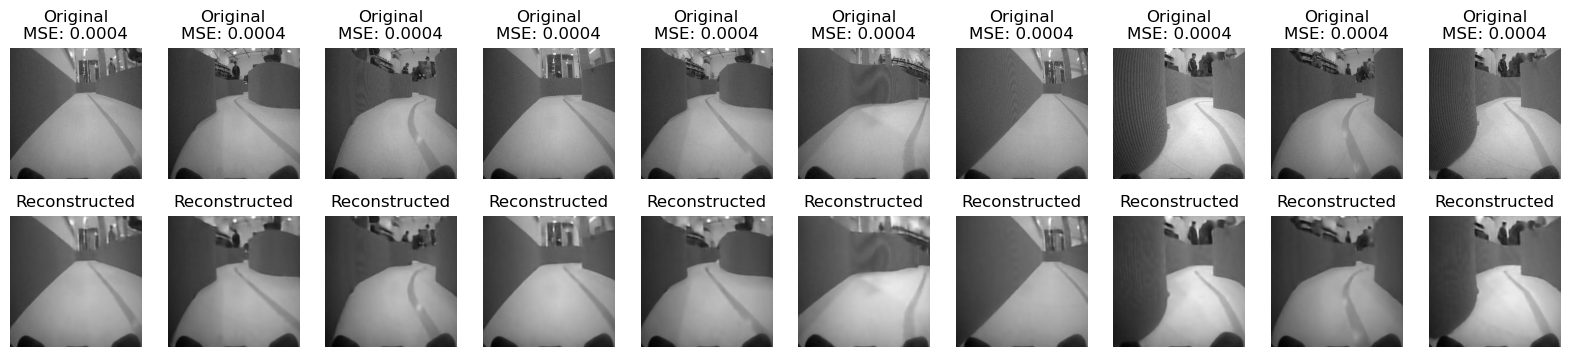

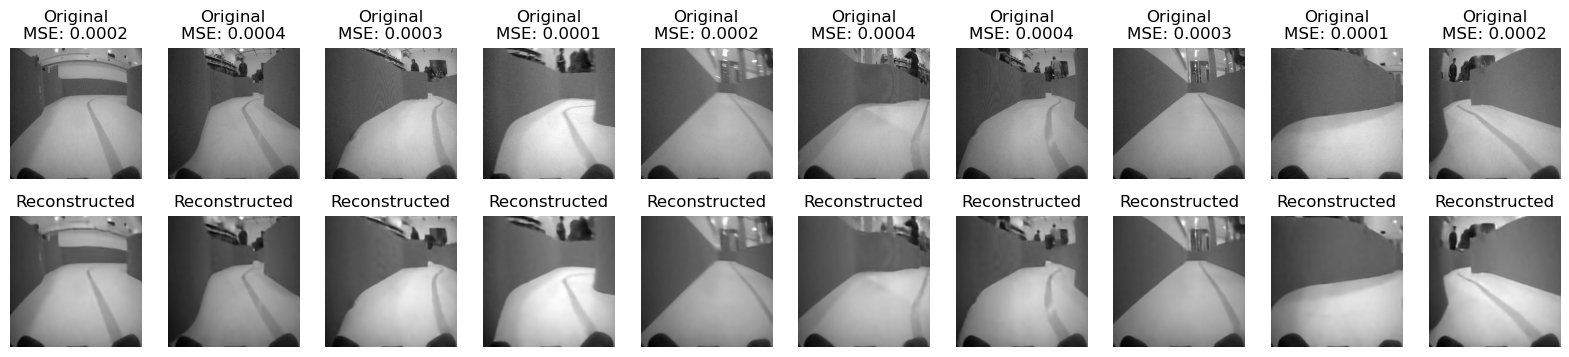

In [41]:
# Visualization function
def display_images(images, reconstructed_images, reconstruction_errors, indices, num_images=10):
    plt.figure(figsize=(20, 4))
    for i, idx in enumerate(indices[:num_images]):
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(images[idx].reshape(224, 224), cmap='gray')
        plt.title(f"Original\nMSE: {reconstruction_errors[idx]:.4f}")
        plt.axis("off")
        
        ax = plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(reconstructed_images[idx].reshape(224, 224), cmap='gray')
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()

# Display sample images from the top 100 high MSE images
display_images(images, reconstructed_images, reconstruction_errors, top_100_indices, num_images=10)

# Display sample images from random images
random_indices = np.random.choice(len(images), 10, replace=False)
display_images(images, reconstructed_images, reconstruction_errors, random_indices, num_images=10)